In [1]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [2]:
CUDA_LAUNCH_BLOCKING=1

In [3]:
!pip install pycocotools --quiet
!git clone https://github.com/pytorch/vision.git
!git checkout v0.3.0

!cp vision/references/detection/utils.py ./
!cp vision/references/detection/transforms.py ./
!cp vision/references/detection/coco_eval.py ./
!cp vision/references/detection/engine.py ./
!cp vision/references/detection/coco_utils.py ./

Cloning into 'vision'...
remote: Enumerating objects: 202375, done.
remote: Counting objects: 100% (3101/3101), done.
remote: Compressing objects: 100% (376/376), done.
remote: Total 202375 (delta 2788), reused 2999 (delta 2719), pack-reused 199274
Receiving objects: 100% (202375/202375), 401.38 MiB | 37.36 MiB/s, done.
Resolving deltas: 100% (182396/182396), done.
fatal: not a git repository (or any of the parent directories): .git


In [4]:
import numpy as np
import pandas as pd
import os 

In [5]:
import torch
import torchvision
from torchvision import datasets, models
from torchvision.transforms import functional as FT
from torchvision import transforms as T
from torch import nn, optim
from torch.nn import functional as F
from torch.utils.data import DataLoader, sampler, random_split, Dataset
import copy
import math
from PIL import Image
import cv2
import albumentations as A  # our data augmentation library
from engine import train_one_epoch, evaluate
import utils
import sys

import matplotlib.pyplot as plt
import matplotlib.patches as patches
%matplotlib inline

In [6]:
import warnings
warnings.filterwarnings("ignore")
from collections import defaultdict, deque
import datetime
import time
from tqdm import tqdm # progress bar
from torchvision.utils import draw_bounding_boxes

In [7]:
!pip install pycocotools
from pycocotools.coco import COCO

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [8]:
from albumentations.pytorch import ToTensorV2

In [9]:
def get_transforms(train=False):
    if train:
        transform = A.Compose([
            A.Resize(600, 600), # our input size can be 600px
            A.HorizontalFlip(p=0.3),
            A.VerticalFlip(p=0.3),
            A.RandomBrightnessContrast(p=0.1),
            A.ColorJitter(p=0.1),
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='coco'))
    else:
        transform = A.Compose([
            A.Resize(600, 600), # our input size can be 600px
            ToTensorV2()
        ], bbox_params=A.BboxParams(format='coco'))
    return transform

In [10]:
class FruitDetection(datasets.VisionDataset):
    def __init__(self, root, split='train', transform=None, target_transform=None, transforms=None):
        # the 3 transform parameters are reuqired for datasets.VisionDataset
        super().__init__(root, transforms, transform, target_transform)
        self.split = split #train, valid, test
        self.coco = COCO(os.path.join(root, split, "_annotations.coco.json")) # annotatiosn stored here
        self.ids = list(sorted(self.coco.imgs.keys()))
        self.ids = [id for id in self.ids if (len(self._load_target(id)) > 0)]
    
    def _load_image(self, id: int):
        path = self.coco.loadImgs(id)[0]['file_name']
        image = cv2.imread(os.path.join(self.root, self.split, path))
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        return image
    def _load_target(self, id):
        return self.coco.loadAnns(self.coco.getAnnIds(id))
    
    def __getitem__(self, index):
        id = self.ids[index]
        image = self._load_image(id)
        target = self._load_target(id)
        target = copy.deepcopy(self._load_target(id))
        
        boxes = [t['bbox'] + [t['category_id']] for t in target] # required annotation format for albumentations
        if self.transforms is not None:
            transformed = self.transforms(image=image, bboxes=boxes)
        
        image = transformed['image']
        boxes = transformed['bboxes']
        
        new_boxes = [] # convert from xywh to xyxy
        for box in boxes:
            xmin = box[0]
            xmax = xmin + box[2]
            ymin = box[1]
            ymax = ymin + box[3]
            new_boxes.append([xmin, ymin, xmax, ymax])
        
        boxes = torch.tensor(new_boxes, dtype=torch.float32)
        
        targ = {} # here is our transformed target
        targ['boxes'] = boxes
        targ['labels'] = torch.tensor([t['category_id'] for t in target], dtype=torch.int64)
        # targ['image_id'] = torch.tensor([t['image_id'] for t in target])
        image_id = torch.tensor([index])
        targ["image_id"] = image_id
        targ['area'] = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0]) # we have a different area
        # targ['iscrowd'] = torch.tensor([t['iscrowd'] for t in target], dtype=torch.int64)
        targ['iscrowd'] = torch.zeros((boxes.shape[0],), dtype=torch.int64)

        return image.div(255), targ # scale images
    def __len__(self):
        return len(self.ids)

In [11]:
dataset_path = '/content/gdrive/MyDrive/Colab_Notebooks/rcnn_dataset/pepper_test_4.v5i.coco/'

In [12]:
#load classes
coco = COCO(os.path.join(dataset_path, "train", "_annotations.coco.json"))
categories = coco.cats
n_classes = len(categories.keys())
categories

loading annotations into memory...
Done (t=3.94s)
creating index...
index created!


{0: {'id': 0,
  'name': 'pepperphase4-pepper-detectrot',
  'supercategory': 'none'},
 1: {'id': 1,
  'name': 'check',
  'supercategory': 'pepperphase4-pepper-detectrot'},
 2: {'id': 2,
  'name': 'green pepper',
  'supercategory': 'pepperphase4-pepper-detectrot'},
 3: {'id': 3,
  'name': 'red pepper',
  'supercategory': 'pepperphase4-pepper-detectrot'},
 4: {'id': 4, 'name': 'rot', 'supercategory': 'pepperphase4-pepper-detectrot'}}

In [13]:
classes = [i[1]['name'] for i in categories.items()]
classes

['pepperphase4-pepper-detectrot', 'check', 'green pepper', 'red pepper', 'rot']

In [14]:
train_dataset = FruitDetection(root=dataset_path, transforms=get_transforms(True))
test_dataset = FruitDetection(root=dataset_path, split="test", transforms=get_transforms(False))

loading annotations into memory...
Done (t=0.02s)
creating index...
index created!
loading annotations into memory...
Done (t=0.51s)
creating index...
index created!


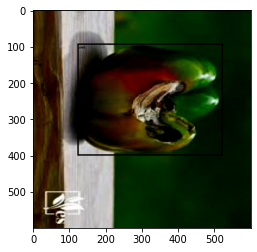

In [15]:
sample = train_dataset[2]
img_int = torch.tensor(sample[0] * 255, dtype=torch.uint8)
plt.imshow(draw_bounding_boxes(
    img_int, sample[1]['boxes'], [classes[i] for i in sample[1]['labels']], width=4
).permute(1, 2, 0))

In [16]:
len(train_dataset)

1301

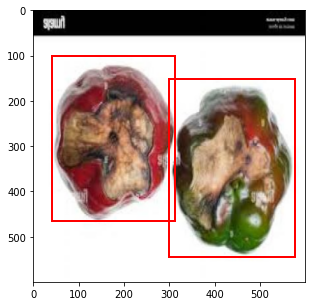

In [17]:
# Function to visualize bounding boxes in the image

def plot_img_bbox(img, target):
    # plot the image and bboxes
    # Bounding boxes are defined as follows: x-min y-min width height
    fig, a = plt.subplots(1,1)
    fig.set_size_inches(5,5)
    a.imshow(img.permute(1, 2, 0))
    for box in (target['boxes']):
        x, y, width, height  = box[0], box[1], box[2]-box[0], box[3]-box[1]
        rect = patches.Rectangle((x, y),
                                 width, height,
                                 linewidth = 2,
                                 edgecolor = 'r',
                                 facecolor = 'none')

        # Draw the bounding box on top of the image
        a.add_patch(rect)
    plt.show()
    
# plotting the image with bboxes. Feel free to change the index
img, target = train_dataset[25]
plot_img_bbox(img, target)

In [18]:
def get_object_detection_model(num_classes):

    # load a model pre-trained pre-trained on COCO
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    
    # get number of input features for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    # replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes) 

    return model

In [19]:
# use our dataset and defined transformations
dataset = FruitDetection(root=dataset_path, transforms= get_transforms(train=True))
dataset_test = FruitDetection(root=dataset_path, transforms= get_transforms(train=False))

# split the dataset in train and test set
torch.manual_seed(1)
indices = torch.randperm(len(dataset)).tolist()

# train test split
test_split = 0.2
tsize = int(len(dataset)*test_split)
dataset = torch.utils.data.Subset(dataset, indices[:-tsize])
dataset_test = torch.utils.data.Subset(dataset_test, indices[-tsize:])

# define training and validation data loaders
data_loader = torch.utils.data.DataLoader(
    dataset, batch_size=4, shuffle=True, num_workers=4,
    collate_fn=utils.collate_fn)

data_loader_test = torch.utils.data.DataLoader(
    dataset_test, batch_size=4, shuffle=False, num_workers=4,
    collate_fn=utils.collate_fn)

loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
loading annotations into memory...
Done (t=0.02s)
creating index...
index created!


In [20]:
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection import FasterRCNN
from torchvision.models.detection.rpn import AnchorGenerator

from torch.utils.data import DataLoader, Dataset
from torch.utils.data import SequentialSampler

# to train on gpu if selected.
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

num_classes = 5

# get the model using our helper function
model = get_object_detection_model(num_classes)

# move model to the right device
model.to(device)

# construct an optimizer
params = [p for p in model.parameters() if p.requires_grad]
optimizer = torch.optim.SGD(params, lr=0.01,
                            momentum=0.9, weight_decay=0.0005)

# and a learning rate scheduler which decreases the learning rate by
# 10x every 3 epochs
lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=3,
                                               gamma=0.1)

Downloading: "https://download.pytorch.org/models/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth" to /root/.cache/torch/hub/checkpoints/fasterrcnn_resnet50_fpn_coco-258fb6c6.pth


  0%|          | 0.00/160M [00:00<?, ?B/s]

In [21]:
# training for 10 epochs
num_epochs = 15

for epoch in range(num_epochs):
    # training for one epoch
    train_one_epoch(model, optimizer, data_loader, device, epoch, print_freq=10)
    # update the learning rate
    # lr_scheduler.step()
    # evaluate on the test dataset
    evaluate(model, data_loader_test, device=device)

Epoch: [0]  [  0/261]  eta: 0:48:01  lr: 0.000048  loss: 1.8367 (1.8367)  loss_classifier: 1.6395 (1.6395)  loss_box_reg: 0.1878 (0.1878)  loss_objectness: 0.0074 (0.0074)  loss_rpn_box_reg: 0.0021 (0.0021)  time: 11.0406  data: 0.9587  max mem: 3014
Epoch: [0]  [ 10/261]  eta: 0:06:58  lr: 0.000433  loss: 1.3525 (1.2474)  loss_classifier: 1.2173 (1.0819)  loss_box_reg: 0.1485 (0.1567)  loss_objectness: 0.0052 (0.0066)  loss_rpn_box_reg: 0.0017 (0.0022)  time: 1.6692  data: 0.1031  max mem: 3277
Epoch: [0]  [ 20/261]  eta: 0:04:54  lr: 0.000817  loss: 0.6518 (0.8923)  loss_classifier: 0.3821 (0.7034)  loss_box_reg: 0.1603 (0.1798)  loss_objectness: 0.0052 (0.0066)  loss_rpn_box_reg: 0.0017 (0.0026)  time: 0.7330  data: 0.0167  max mem: 3277
Epoch: [0]  [ 30/261]  eta: 0:04:06  lr: 0.001201  loss: 0.4057 (0.7263)  loss_classifier: 0.2063 (0.5416)  loss_box_reg: 0.1727 (0.1755)  loss_objectness: 0.0051 (0.0061)  loss_rpn_box_reg: 0.0024 (0.0031)  time: 0.7388  data: 0.0157  max mem: 3277

In [22]:
model.eval()
torch.cuda.empty_cache()

In [32]:
img, _ = test_dataset[1]

with torch.no_grad():
    prediction = model([img.to(device)])
    pred = prediction[0]

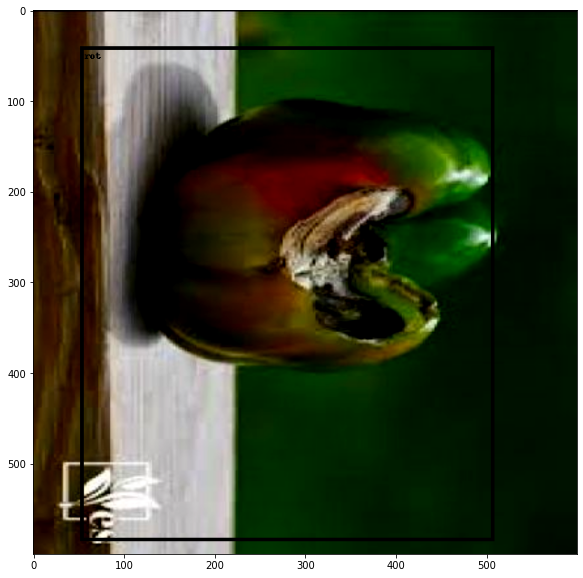

In [33]:
fig = plt.figure(figsize=(14, 10))
plt.imshow(draw_bounding_boxes(img_int,
    pred['boxes'][pred['scores'] > 0.8],
    [classes[i] for i in pred['labels'][pred['scores'] > 0.8].tolist()], width=4
).permute(1, 2, 0))

In [25]:
model_save_name = 'Fruit Faster R-CNN.pt'
path = F"/content/gdrive/My Drive/Colab_Notebooks/{model_save_name}" 
torch.save(model.state_dict(), path)
print(f'{model_save_name} saved successfully.')

Fruit Faster R-CNN.pt saved successfully.


In [26]:
!wget https://plantvillage-production-new.s3.amazonaws.com/images/pics/000/001/278/original/1573722-SMPT.jpg -O test_image.jpg

--2022-08-28 05:36:28--  https://plantvillage-production-new.s3.amazonaws.com/images/pics/000/001/278/original/1573722-SMPT.jpg
Resolving plantvillage-production-new.s3.amazonaws.com (plantvillage-production-new.s3.amazonaws.com)... 54.231.166.9
Connecting to plantvillage-production-new.s3.amazonaws.com (plantvillage-production-new.s3.amazonaws.com)|54.231.166.9|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 132914 (130K) [image/jpeg]
Saving to: ‘test_image.jpg’

test_image.jpg      100%[===================>] 129.80K  --.-KB/s    in 0.06s   

2022-08-28 05:36:28 (2.19 MB/s) - ‘test_image.jpg’ saved [132914/132914]



In [27]:
# the function takes the original prediction and the iou threshold.

def apply_nms(orig_prediction, iou_thresh=0.3):
    
    # torchvision returns the indices of the bboxes to keep
    keep = torchvision.ops.nms(orig_prediction['boxes'], orig_prediction['scores'], iou_thresh)
    
    final_prediction = orig_prediction
    final_prediction['boxes'] = final_prediction['boxes'][keep]
    final_prediction['scores'] = final_prediction['scores'][keep]
    final_prediction['labels'] = final_prediction['labels'][keep]
    
    return final_prediction

# function to convert a torchtensor back to PIL image
def torch_to_pil(img):
    return T.ToPILImage()(img).convert('RGB')

In [28]:
# pick one image from the test set
img, target = dataset_test[5]
# put the model in evaluation mode
model.eval()
with torch.no_grad():
    prediction = model([img.to(device)])[0]
    
print('predicted #boxes: ', len(prediction['labels']))
print('real #boxes: ', len(target['labels']))

predicted #boxes:  3
real #boxes:  1


loading annotations into memory...
Done (t=0.01s)
creating index...
index created!
EXPECTED OUTPUT



AttributeError: ignored

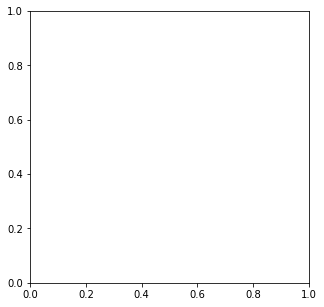

In [29]:
# test_dataset = FruitDetection(root=dataset_path, split="test", transforms= get_transforms(train=True))
# # pick one image from the test set
# img, target = test_dataset[10]
# # put the model in evaluation mode
# model.eval()
# with torch.no_grad():
#     prediction = model([img.to(device)])[0]
    
# print('EXPECTED OUTPUT\n')
# plot_img_bbox(torch_to_pil(img), target)
# print('MODEL OUTPUT\n')
# nms_prediction = apply_nms(prediction, iou_thresh=0.01)

# plot_img_bbox(torch_to_pil(img), nms_prediction)

In [35]:
def obj_detector(image):
    image = cv2.imread(image, cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB).astype(np.float32)


    image /= 255.0
    image = torch.from_numpy(image)
    image = image.unsqueeze(0)
    image = image.permute(0,3,1,2)
    
    model.eval()

    detection_threshold = 0.70
    
    image = list(im.to(device) for im in image)
    output = model(image)

    for i , im in enumerate(image):
        boxes = output[i]['boxes'].data.cpu().numpy()
        scores = output[i]['scores'].data.cpu().numpy()
        labels = output[i]['labels'].data.cpu().numpy()

        labels = labels[scores >= detection_threshold]
        boxes = boxes[scores >= detection_threshold].astype(np.int32)
        scores = scores[scores >= detection_threshold]

        boxes[:, 2] = boxes[:, 2] - boxes[:, 0]
        boxes[:, 3] = boxes[:, 3] - boxes[:, 1]
    
    sample = image[0].permute(1,2,0).cpu().numpy()
    sample = np.array(sample)
    boxes = output[0]['boxes'].data.cpu().numpy()
    name = output[0]['labels'].data.cpu().numpy()
    scores = output[0]['scores'].data.cpu().numpy()
    boxes = boxes[scores >= detection_threshold].astype(np.int32)
    names = name.tolist()
    
    return names, boxes, sample

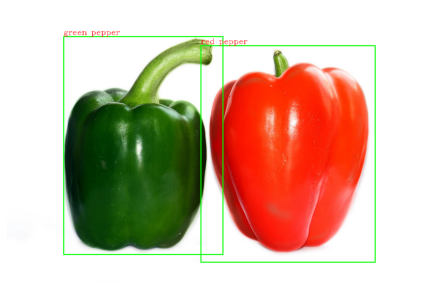

In [36]:
pred_path = "/content/gdrive/My Drive/Colab_Notebooks/rcnn_dataset/pred"
pred_files = [os.path.join(pred_path,f) for f in os.listdir(pred_path)]

plt.figure(figsize=(20,60))
# plt.figure(figsize=(30, 70))
for i, images in enumerate(pred_files):
    if i > 19:break
    plt.subplot(10,2,i+1)
    names,boxes,sample = obj_detector(images)
    for i,box in enumerate(boxes):
        cv2.rectangle(sample,
                      (box[0], box[1]),
                      (box[2], box[3]),
                      (0, 220, 0), 2)
        cv2.putText(sample, classes[names[i]], (box[0],box[1]-5),cv2.FONT_HERSHEY_COMPLEX ,0.7,(220,0,0),1,cv2.LINE_AA)  

    plt.axis('off')
    plt.imshow(sample)
    plt.savefig('save_images.png', bbox_inches='tight',)  # if you want to save result